# Install library

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

## Dataset preprocessing and EDA

In [44]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


In [45]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 3072)
(50000, 1)
(10000, 3072)
(10000, 1)


In [46]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [47]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_ind = np.where(cifar10_labels=='bird')
deer_ind = np.where(cifar10_labels=='deer')
truck_ind = np.where(cifar10_labels=='truck')

In [48]:
remove_num = 2500
counter = 0
train_num = len(y_train) - remove_num * 3 # for 3 classes
x_train_removed =  np.zeros(x_train.shape)[:train_num]
y_train_removed =  np.zeros(y_train.shape)[:train_num]

# bird, deer, truck labeld data is removed by 2500
bird_limit, deer_limit, truck_limit = 0, 0, 0
for i, label in enumerate(y_train):
    if (label != bird_ind) & (label != deer_ind) & (label != truck_ind):
        x_train_removed[counter] = x_train[i]
        y_train_removed[counter] = y_train[i]
        counter += 1
    else:
        if label == bird_ind:
            if bird_limit < 2500:
                bird_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue
        if label == deer_ind:
            if deer_limit < 2500:
                deer_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue
        if label == truck_ind:
            if truck_limit < 2500:
                truck_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue

y_train_removed = np.array(y_train_removed, dtype='uint8')

In [50]:
print(x_train_removed.shape)
print(y_train_removed.shape)

(42500, 3072)
(42500, 1)


In [51]:
df = pd.DataFrame(y_train_removed.flatten())
df.value_counts()

8    5000
7    5000
6    5000
5    5000
3    5000
1    5000
0    5000
9    2500
4    2500
2    2500
dtype: int64

(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

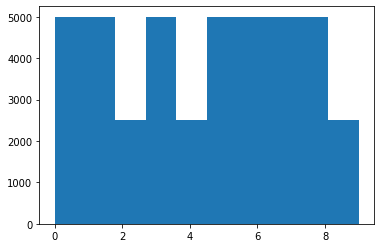

In [52]:
import matplotlib.pyplot as plt

# データ数をプロット
plt.hist(y_train_removed.flatten())

In [66]:
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
# input_img = tf.keras.Input(shape=(784,))
input_img = tf.keras.Input(shape=(3072,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
# decoded = layers.Dense(784, activation='sigmoid')(encoded)
decoded = layers.Dense(3072, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)

# For encode
# This model maps an input to its encoded representation
encoder = tf.keras.Model(input_img, encoded)

# For encode
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = tf.keras.Model(encoded_input, decoder_layer(encoded_input))

In [67]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [72]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
196/196 [==============================] - 1s 4ms/step - loss: 0.6108 - val_loss: 0.6114
Epoch 2/50
196/196 [==============================] - 1s 4ms/step - loss: 0.6102 - val_loss: 0.6107
Epoch 3/50
196/196 [==============================] - 1s 4ms/step - loss: 0.6098 - val_loss: 0.6104
Epoch 4/50
196/196 [==============================] - 1s 4ms/step - loss: 0.6095 - val_loss: 0.6102
Epoch 5/50
196/196 [==============================] - 1s 4ms/step - loss: 0.6094 - val_loss: 0.6100
Epoch 6/50
196/196 [==============================] - 1s 4ms/step - loss: 0.6091 - val_loss: 0.6099
Epoch 7/50
196/196 [==============================] - 1s 4ms/step - loss: 0.6090 - val_loss: 0.6103
Epoch 8/50
196/196 [==============================] - 1s 4ms/step - loss: 0.6090 - val_loss: 0.6098
Epoch 9/50
196/196 [==============================] - 1s 4ms/step - loss: 0.6089 - val_loss: 0.6097
Epoch 10/50
196/196 [==============================] - 1s 4ms/step - loss: 0.6089 - val_loss: 0.6098

In [69]:
autoencoder.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                98336     
_________________________________________________________________
dense_13 (Dense)             (None, 3072)              101376    
Total params: 199,712
Trainable params: 199,712
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

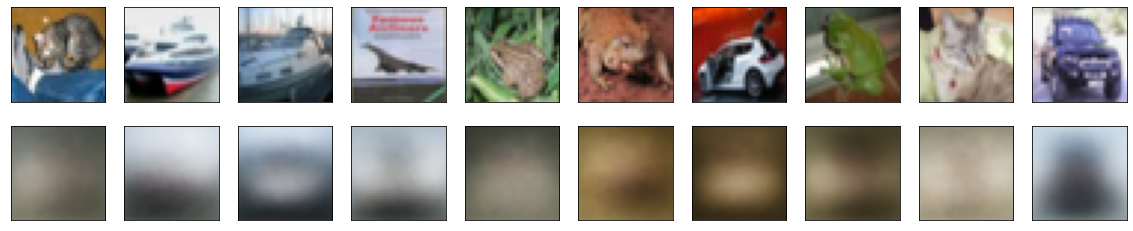

In [74]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()